In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import librosa
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Memory monitor
from my_memory_profiler import profile

<h4>Calcular Extension</h4>

In [36]:
def calculate_extension(data_dir, sample_rate, time_leng, overlap):

    def label_generator(data_dir):
        data_list = []
        
        for dirname, _, filenames in os.walk(data_dir):
            for filename in filenames:
                if filename.endswith('.wav'):  
                    identifiers = filename.split('.')[0].split('_')
                    Speaker_ID = int(identifiers[-1])
                    Label = 1 if identifiers[0] == 'PD' else 0
                    data_list.append({
                        "Speaker_ID": Speaker_ID,
                        "Label": Label,
                        "FileName": filename
                    })
        
        audio_labels = pd.DataFrame(data_list)
            
        return audio_labels
    
    def num_seg(data_dir, audio_labels, SAMPLE_RATE, time_leng, overloap, output_csv=None, filenames=False):
        sample_leng=int(time_leng*SAMPLE_RATE)
        segments_info=[]

        for data_ind, audio_label in enumerate(audio_labels.values):
            file_name=audio_label[-1]
            data_path=os.path.join(data_dir, file_name)
            audio, sample_rate = librosa.load(data_path, sr=SAMPLE_RATE)
            audio_len=len(audio)
            audio=audio/np.max(abs(audio))
            indx=[i for i,x in enumerate(np.sqrt(abs(audio))) if x>.30]
            segments=0
            if (indx[0]+sample_leng)<audio_len:
                for i in range(int((-indx[0]+indx[len(indx)-1])/(sample_leng/overloap))):
                    ind_start = i * int(sample_leng/overloap)+indx[0]
                    ind_end = ind_start + sample_leng
                    if ind_end <= indx[-1]:
                        segments+=1
                if filenames:
                    segments_info.append({
                        'Filename': file_name,
                        'Segments': segments})
                else: 
                    segments_info.append({'Segments':segments})
            else:
                
                if filenames:
                    segments_info.append({
                        'Filename': file_name,
                        'Segments': segments})
                else: 
                    segments_info.append({'Segments':segments})
            if data_ind%50==0 : print(" Processed {}/{} files".format(data_ind,len(audio_labels)-1),end='\n')
        
        df_segments = pd.DataFrame(segments_info)
        if(output_csv is None):
            return df_segments
        else:
            df_segments.to_csv(output_csv, index=False)
    
    labels=label_generator(data_dir)
    segments=num_seg(data_dir, labels, sample_rate, time_leng, overlap)
    extension_DB=pd.concat([labels, segments], axis=1)
    extension_DB.to_csv('extension.csv', index=False)
    print("Se ha creado el fichero extension.csv en el cwd")

<h4>Funciones de preprocesado</h4>

In [3]:
def process_select_signals(data_path, sample_rate):
    segment_length=0.4
    overlap_factor=2
    amplitude_threshold=0.30
    audio, _ = librosa.load(data_path, sr=sample_rate)
    audio_len = len(audio)
    audio = audio / np.max(np.abs(audio)) 

    time_length = segment_length
    sample_length = int(time_length * sample_rate)
    overlap = overlap_factor

    signals = []
    y_label = []
    subject_group = []

    indx = [i for i, x in enumerate(np.sqrt(np.abs(audio))) if x > amplitude_threshold]

    segments = 0
    if len(indx) > 0 and (indx[0] + sample_length) < audio_len:
        for i in range(int((-indx[0] + indx[-1]) / (sample_length / overlap))):
            ind_start = i * int(sample_length / overlap) + indx[0]
            ind_end = ind_start + sample_length
            if ind_end <= indx[-1]:
                signal = np.zeros(sample_length)
                signal = audio[ind_start:int(ind_end)]
                signals.append(signal)
                y_label.append('Label') 
                subject_group.append('Speaker_ID')  
                segments += 1

    signals = np.stack(signals, axis=0) if signals else np.empty((0, sample_length))
    y_label = np.array(y_label)
    subject_group = np.array(subject_group)

    return signals

def to_spectrogram(signal, sample_rate):
    n_fft = 2048
    win_length = int(0.015*sample_rate) 
    hop_length = int(0.010*sample_rate)
    n_mels = 65 

    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=n_mels,
        mel_scale="htk",
    )

    scaler = StandardScaler()
    
    mel_spect = librosa.power_to_db(mel_spectrogram(torch.from_numpy(signal)))
    mel_spect_norm=scaler.fit_transform(mel_spect)
    
    return mel_spect_norm


<h4>Definición del Dataset</h4>

In [30]:
class CustomAudioDataset(Dataset):

    def __init__(self, data_dir, sample_rate, time_leng, overlap, to_spectrogram=False, have_extension=True):
        
        if have_extension is False:
            calculate_extension(data_dir, sample_rate, time_leng, overlap)
        

        try:
            extension = pd.read_csv('extension.csv')
        except Exception:
            raise FileNotFoundError("No tiene extension.csv en el cwd, cambie su nombre o localización o marque have_extension=False")

        self.labels=extension['Label'].values
        self.IDs=extension['Speaker_ID'].values
        self.filenames=extension['FileName'].values
        self.num_segs=extension['Segments'].values
        self.spec_id_to_file_id = np.concatenate([np.full(count, idx) for idx, count in enumerate(self.num_segs)])

        # sample rate y path al directorio
        self.sample_rate=sample_rate
        self.data_dir=data_dir

        # to_spectrogram: True or False
        self.to_spectrogram=to_spectrogram

        # signal index
        signal_index=[]
        for number in self.num_segs:
            for i in range(number):
                signal_index.append(i)

        self.signal_index=signal_index

        
        
        
    def __len__(self):

        # numero de segmentos/espectrogramas que puede obtener getitem
        return len(self.spec_id_to_file_id)
    
    def __getitem__(self, idx):

        # mapeo de indices: file_index es el que se usa para hacer el fetch al DB. 
        file_index=self.spec_id_to_file_id[idx]

        ### if(file_index in self.isincache): 

        # data_path = directory/path + /filename.wav
        data_path=os.path.join(self.data_dir, self.filenames[file_index])

        print(f"fetched segment {self.signal_index[idx]} of audio {self.filenames[file_index]}")

        # audio, sample_rate = librosa.load(data_path, sr=SAMPLE_RATE)
        label=self.labels[file_index]
        subject_group= self.IDs[file_index]

        signals=process_select_signals(data_path, self.sample_rate)
        
        if(self.to_spectrogram):
            audio=to_spectrogram(signals[self.signal_index[idx]], self.sample_rate)
            ### self.cache = [to_spectrogram(sig) for sig in signals_cache]
        else:
            audio=signals[idx]
            ### self.cache=signals
        
        return audio, label, subject_group

<h4>Pruebas</h4>

1. Inicialización del dataset y generación de la extensión si no se dispone de ella

In [33]:
DATA_PATH_NeuroV = 'neurovoz/zenodo_upload/audios/'
SAMPLE_RATE=44100

datasetAudio = CustomAudioDataset(DATA_PATH_NeuroV, SAMPLE_RATE, time_leng=0.4, overlap=2, to_spectrogram=True, have_extension=False)

 Processed 0/2903 files
 Processed 50/2903 files
 Processed 100/2903 files
 Processed 150/2903 files
 Processed 200/2903 files
 Processed 250/2903 files
 Processed 300/2903 files
 Processed 350/2903 files
 Processed 400/2903 files
 Processed 450/2903 files
 Processed 500/2903 files
 Processed 550/2903 files
 Processed 600/2903 files
 Processed 650/2903 files
 Processed 700/2903 files
 Processed 750/2903 files
 Processed 800/2903 files
 Processed 850/2903 files
 Processed 900/2903 files
 Processed 950/2903 files
 Processed 1000/2903 files
 Processed 1050/2903 files
 Processed 1100/2903 files
 Processed 1150/2903 files
 Processed 1200/2903 files
 Processed 1250/2903 files
 Processed 1300/2903 files
 Processed 1350/2903 files
 Processed 1400/2903 files
 Processed 1450/2903 files
 Processed 1500/2903 files
 Processed 1550/2903 files
 Processed 1600/2903 files
 Processed 1650/2903 files
 Processed 1700/2903 files
 Processed 1750/2903 files
 Processed 1800/2903 files
 Processed 1850/2903 fil

2. Demostración del dataloader

fetched segment 6 of audio PD_BARBAS_0020.wav
fetched segment 11 of audio HC_PATAKA_0061.wav
fetched segment 295 of audio HC_ESPONTANEA_0034.wav
fetched segment 7 of audio PD_A1_0039.wav
fetched segment 0 of audio HC_MANGA_0055.wav
fetched segment 262 of audio HC_ESPONTANEA_0138.wav
fetched segment 87 of audio HC_ESPONTANEA_0054.wav
fetched segment 21 of audio PD_PATAKA_0113.wav
fetched segment 172 of audio HC_ESPONTANEA_0138.wav


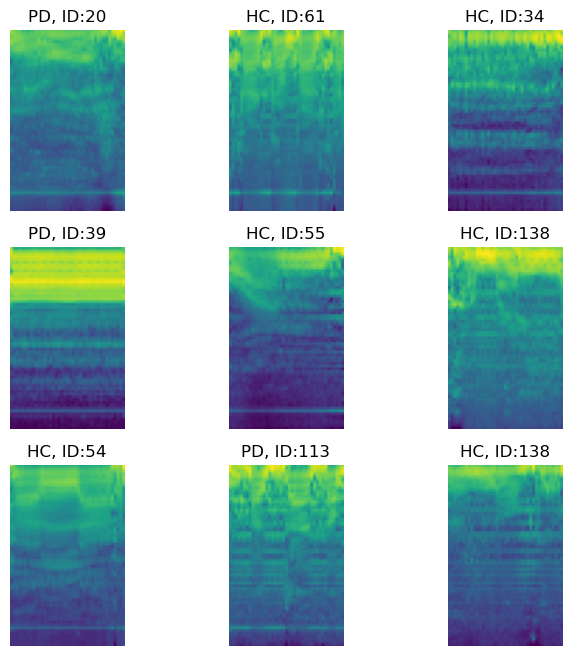

In [34]:
extension_DB=pd.read_csv('extension.csv')
DATASET_SIZE=extension_DB['Segments'].sum()
BATCH_SIZE=9

dataloader = DataLoader(datasetAudio, batch_size=BATCH_SIZE, shuffle=True)

spectrogram_batch, label_batch, subject_batch = next(iter(dataloader))


figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1,BATCH_SIZE+1):
    sample_idx= i-1
    img = spectrogram_batch[sample_idx]
    label=label_batch[sample_idx]
    subject=subject_batch[sample_idx]
    figure.add_subplot(rows, cols, i)
    if label:
        title='PD'
    else:
        title='HC'
    plt.title('{}, ID:{}'.format(title,subject))
    plt.axis("off")
    plt.imshow(img.squeeze())

3. Demostración dentro de un bucle de entrenamiento

In [40]:
BATCH_SIZE=32
iters=int(DATASET_SIZE/BATCH_SIZE)

dataloader = DataLoader(datasetAudio, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(200):

    for i in range(iters):

        spectrogram_batch, label_batch, subject_batch = next(iter(dataloader))
        print("---------------------------------------------------")
        print("batch {}/{}".format(i, iters), end='\n')
    print("#################################################")
    print("epoch {}/200".format(epoch,end='\n'))

        

fetched segment 8 of audio HC_DIABLO_0142.wav
fetched segment 6 of audio PD_PIDIO_0020.wav
fetched segment 14 of audio PD_ESPONTANEA_0047.wav
fetched segment 6 of audio PD_PIDIO_0009.wav
fetched segment 6 of audio PD_E2_0042.wav
fetched segment 7 of audio PD_PERRO_0013.wav
fetched segment 125 of audio HC_ESPONTANEA_0087.wav
fetched segment 3 of audio PD_BARBAS_0047.wav
fetched segment 378 of audio HC_ESPONTANEA_0145.wav
fetched segment 7 of audio PD_E1_0035.wav
fetched segment 4 of audio PD_PATAKA_0030.wav
fetched segment 3 of audio HC_CALLE_0133.wav
fetched segment 4 of audio PD_SOMBRA_0018.wav
fetched segment 10 of audio PD_O2_0031.wav
fetched segment 1 of audio PD_PATATA_BLANDA_0027.wav
fetched segment 45 of audio PD_PATAKA_0013.wav
fetched segment 9 of audio PD_I1_0023.wav
fetched segment 3 of audio HC_E1_0130.wav
fetched segment 18 of audio HC_ESPONTANEA_0135.wav
fetched segment 1 of audio PD_A2_0041.wav
fetched segment 15 of audio PD_A2_0026.wav
fetched segment 37 of audio PD_PAT

KeyboardInterrupt: 